In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import faiss
import time
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import cv2
from attention_unet import Attention_block, conv_block, up_conv
import matplotlib.pyplot as plt
from dataloaders import ShapeDataset
import torchvision.utils

In [2]:
dataset_path = Path('/home/e_radionova/Datasets/SimpleShapes_10_classes/dataset/')

In [3]:
trans = transforms.Compose([
    transforms.Resize((288, 400)),
    transforms.ToTensor(),
])

train_set = ShapeDataset(images_folder = dataset_path / 'images', 
                         masks_folder = dataset_path / 'masks',
                         img_transform = trans, 
                         masks_transform = trans)

In [4]:
image_datasets = {
    'train': train_set #, 'val': val_set
}

batch_size_train = 2

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
#     'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2160}

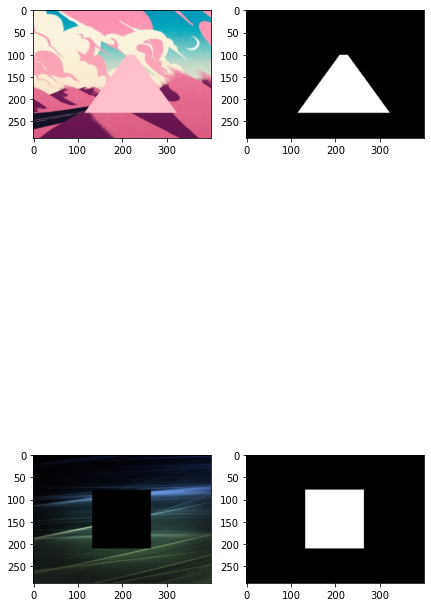

In [5]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

n_pics_to_show = batch_size_train
inputs, masks = next(iter(dataloaders['train']))
fig, ax = plt.subplots(n_pics_to_show, 2, figsize=(7, 15))
for i in range(n_pics_to_show):
    pic, label = inputs[i], masks[i] 
    label_np = label.data.numpy().transpose(1, 2, 0) 
    pic_np = pic.data.numpy().transpose(1, 2, 0) 
    ax[i,0].imshow(pic_np)
    ax[i,1].imshow(label_np)

In [6]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss, calc_loss, print_metrics
# from attention_maps_funcs import get_activation, plot_attention_map
from tqdm.notebook import tqdm

In [7]:
logs_base_dir = Path('./logs')
logs_base_dir.mkdir(exist_ok=True)

In [8]:
experiment_name = 'Test_round'
logs_exp = logs_base_dir / experiment_name
logs_base_dir.mkdir(exist_ok=True)

In [9]:
from template_matching_funcs import thresholding

activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def plot_attention_map(attention_map, N=10, n_columns=5):
    normed_att_map = transforms.Normalize(0, 1)(attention_map).detach().cpu().numpy()

#     clear_output(wait=True)
    
    n_rows = N // n_columns + int(N // n_columns * n_columns < N)
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15,6))
    for map_i in range(N):
        if N==1:
            plt.imshow(normed_att_map[map_i])
        else:
            row_index = map_i // n_columns
            column_index = map_i % n_columns
            axes[row_index, column_index].imshow(normed_att_map[map_i])
    plt.show()
    

def get_feature_map(attention_map, index=9, threshold=True):
    normed_att_map = attention_map.detach().cpu().numpy()
    one_layer = normed_att_map[index]
    plt.imshow(one_layer)
    plt.title('Choosen map')
    plt.show()
    print('Unique els: ', np.unique(one_layer))
    if threshold:
        fm_thresh = thresholding(one_layer, 1.0)
        kern = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
        fm_thresh = cv2.morphologyEx(fm_thresh, cv2.MORPH_CLOSE, kern)
        fm_thresh = cv2.dilate(fm_thresh,kern,iterations = 1)
        fm_thresh = 255 * abs(fm_thresh / fm_thresh.max())
        plt.imshow(fm_thresh)
        plt.show()

In [10]:

def train_model(model, optimizer, scheduler, experiment_name, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    best_dice = 0
    
    writer = SummaryWriter(logs_base_dir / experiment_name)

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()
        i = 0
        
        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                
                inputs = inputs.to(device)
                labels = labels.to(device)    

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    ############################################################
                    if i < 10:
                        plot_attention_map(activation['Att4'][0]) # [256, 100, 100]
                        print(activation['Att4'].shape)
                        
                        one_fm = get_feature_map(activation['Att4'][0])
                    ############################################################
                    i+=1
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
                

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples   
            writer.add_scalar(f'Loss_{phase}', epoch_loss.item(), global_step=epoch)
            
            dice_epoch = metrics['dice'] / epoch_samples
            writer.add_scalar(f'DICE_{phase}', dice_epoch.item(), global_step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best loss")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == 'val' and dice_epoch > best_dice:
                print("saving best DICE")
                best_dice = dice_epoch

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val DICE: {:4f}'.format(best_dice))
    
#     file_name = "Best_DICE_" + Model_name + '_' + model_type 
#     with open(f"{files_dir}/{file_name}.txt","a") as the_file:
#             the_file.write('Fold №{}, best DICE: {}\n'.format(fold, best_dice))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
import attention_unet
model = attention_unet.AttU_Net(3, 3).to(device)

In [13]:
model.Att4.register_forward_hook(get_activation('Att4'))

In [14]:
optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

exp_name = datetime.now().isoformat(timespec='minutes') 

In [16]:
model = train_model(model, optimizer_ft, exp_lr_scheduler, experiment_name=exp_name, num_epochs=10) 